In [1]:
CELL_TYPE = 'DC'
N_SPLITS: int = 5
N_TRIALS: int = 50
RUN_NAME: str = "studyID"

In [2]:
# Parameters
CELL_TYPE = "T_CD4_NonNaive"


In [3]:
if RUN_NAME != "":
    RUN_NAME = RUN_NAME + "_"

In [4]:
import os
import sys
#from pyprojroot.here import here

import pandas as pd
import anndata as ad
import numpy as np
import math
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

import optuna

import joblib
import pickle
import datetime

import collections

import xgboost
from sklearn.preprocessing import LabelEncoder

import scipy.sparse as ssp
import joblib

from pyprojroot import here

from dotenv import load_dotenv

In [5]:
assert load_dotenv()

def here(fpath):
    return os.path.join(BUCKET_DIRPATH, fpath)

In [6]:
target_y = 'studyID'

# LOAD DATASET

In [7]:
adata = ad.read_h5ad(
    str(here(f'03_downstream_analysis/08_gene_importance/data/{CELL_TYPE}_adataMerged_SPECTRAgenes.log1p.h5ad')),
    backed='r',
    chunk_size=25000
)

In [8]:
adata.obs

,studyID,libraryID,sampleID,chemistry,disease,sex,binned_age,Level1,Level2
cellID,,,,,,,,,
Perez2022_L032_IGTB1650_T0_AAAGCAAAGACAAAGG,Perez2022,Perez2022_L032,Perez2022_IGTB1650_T0,3_GEX_V2,healthy,female,31-40,T_CD4_NonNaive,Th1
Perez2022_L032_IGTB1650_T0_AAAGTAGCAAATACAG,Perez2022,Perez2022_L032,Perez2022_IGTB1650_T0,3_GEX_V2,healthy,female,31-40,T_CD4_NonNaive,Th1
Perez2022_L032_IGTB1650_T0_AAATGCCGTCCCTACT,Perez2022,Perez2022_L032,Perez2022_IGTB1650_T0,3_GEX_V2,healthy,female,31-40,T_CD4_NonNaive,T_CD4_CM_ribo
Perez2022_L032_IGTB1650_T0_AAATGCCTCACATACG,Perez2022,Perez2022_L032,Perez2022_IGTB1650_T0,3_GEX_V2,healthy,female,31-40,T_CD4_NonNaive,T_CD4_EM
Perez2022_L032_IGTB1650_T0_AAATGCCTCCAACCAA,Perez2022,Perez2022_L032,Perez2022_IGTB1650_T0,3_GEX_V2,healthy,female,31-40,T_CD4_NonNaive,T_CD4_eff
...,...,...,...,...,...,...,...,...,...
Perez2022_L021_1338_T0_TTCTCCTCAGTATCTG,Perez2022,Perez2022_L021,Perez2022_1338_T0,3_GEX_V2,SLE,female,41-50,T_CD4_NonNaive,T_CD4_eff
Perez2022_L021_1338_T0_TTCTTAGCATCGTCGG,Perez2022,Perez2022_L021,Perez2022_1338_T0,3_GEX_V2,SLE,female,41-50,T_CD4_NonNaive,Th0
Perez2022_L021_1338_T0_TTGACTTTCGTCTGCT,Perez2022,Perez2022_L021,Perez2022_1338_T0,3_GEX_V2,SLE,female,41-50,T_CD4_NonNaive,T_CD4_EM


# EXTRACT INDEXES FOR DATA SPLITTING (STRATIFIED BY DISEASE, GROUPED BY PATIENT)

# EXTRACT CELL COUNTS PER SPLIT (TO MAKE SURE THAT RATIOS RESEMBLE 70:20:10)

In [9]:
all_idxs = np.arange(adata.obs.shape[0])
left_out_splits = [s[1] for s in StratifiedGroupKFold(n_splits=N_SPLITS).split(all_idxs, adata.obs[target_y], adata.obs.sampleID)]

min_stats = []
for val_fold_idx, test_fold_idx in product(range(N_SPLITS), range(1,N_SPLITS)):
    if val_fold_idx == test_fold_idx:
        continue

    all_idxs = np.arange(adata.obs.shape[0])
    val_idxs, test_idxs = left_out_splits[val_fold_idx], left_out_splits[test_fold_idx]
    train_idxs = np.delete(all_idxs, np.union1d(val_idxs, test_idxs))

    cell_count_df = []
    cell_count_df.append(adata.obs.iloc[train_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='train'))
    cell_count_df.append(adata.obs.iloc[val_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='val'))
    cell_count_df.append(adata.obs.iloc[test_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='test'))
    cell_count_df = pd.concat(cell_count_df).pivot(index=target_y, columns='split', values='cell_count')
    cell_plot_data = cell_count_df.div(cell_count_df.sum(axis=1), axis=0).reset_index().melt(id_vars=target_y)
    min_stats.append((val_fold_idx, test_fold_idx, cell_plot_data.query('split=="train"').value.min(), cell_plot_data.query('split=="test"').value.min()))

# CALCULATE RATIOS OF PATIENTS IN TRAINING AND TESTING SET: splits that best fit the expected ratios

In [10]:
split_rankings_df = (pd.DataFrame(min_stats, columns=['val_idx', 'test_idx', 'train_min', 'test_mean'])
 .assign(train_min = lambda df: df.train_min / df.train_min.max())
 .assign(test_mean = lambda df: df.test_mean / df.test_mean.max())
 .assign(ranking = lambda df: df.test_mean * df.train_min)
 .sort_values('ranking'))
split_rankings_df

,val_idx,test_idx,train_min,test_mean,ranking
12,3,4,0.863263,0.665693,0.574668
3,0,4,0.920269,0.665693,0.612617
10,3,1,0.692018,0.910847,0.630322
11,3,2,0.836286,0.753941,0.630510
9,2,4,0.977502,0.665693,0.650717
6,1,4,1.000000,0.665693,0.665693
5,1,3,0.692018,1.000000,0.692018
4,1,2,0.928141,0.753941,0.699764
1,0,2,0.947953,0.753941,0.714700
14,4,2,0.977502,0.753941,0.736979


In [11]:
best_split = split_rankings_df.loc[split_rankings_df['ranking'].idxmax()]
all_idxs = np.arange(adata.obs.shape[0])
val_idxs, test_idxs = left_out_splits[best_split.val_idx.astype(int)], left_out_splits[best_split.test_idx.astype(int)]
train_idxs = np.delete(all_idxs, np.union1d(val_idxs, test_idxs))

### CHECK NUMBER OF CELLS PER SPLIT

In [12]:
cell_count_df = []
cell_count_df.append(adata.obs.iloc[train_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='train'))
cell_count_df.append(adata.obs.iloc[val_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='val'))
cell_count_df.append(adata.obs.iloc[test_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='test'))
cell_count_df = pd.concat(cell_count_df).pivot(index=target_y, columns='split', values='cell_count')
cell_plot_data = cell_count_df.div(cell_count_df.sum(axis=1), axis=0).reset_index().melt(id_vars=target_y)

pat_count_df = []
pat_count_df.append(adata.obs.iloc[train_idxs].groupby(target_y, observed=False).sampleID.nunique().to_frame(name='patient_count').reset_index().assign(split='train'))
pat_count_df.append(adata.obs.iloc[val_idxs].groupby(target_y, observed=False).sampleID.nunique().to_frame(name='patient_count').reset_index().assign(split='val'))
pat_count_df.append(adata.obs.iloc[test_idxs].groupby(target_y, observed=False).sampleID.nunique().to_frame(name='patient_count').reset_index().assign(split='test'))
pd.concat(pat_count_df).pivot(index=target_y, columns='split', values='patient_count')
pat_count_df = pd.concat(pat_count_df).pivot(index=target_y, columns='split', values='patient_count')
pat_count_df = pat_count_df.div(pat_count_df.sum(axis=1), axis=0)
pat_plot_data = pat_count_df.div(pat_count_df.sum(axis=1), axis=0).reset_index().melt(id_vars=target_y)

train_pats = set(adata.obs.iloc[train_idxs].sampleID)
test_pats = set(adata.obs.iloc[test_idxs].sampleID)
val_pats = set(adata.obs.iloc[val_idxs].sampleID)

In [13]:
assert val_pats.intersection(test_pats) != {}
assert train_pats.intersection(test_pats) != {}
assert train_pats.intersection(val_pats) != {}

### PLOT PATIENT AND CELL DISTRIBUTION ACROSS TRAIN, TEST, AND VALIDATION SETS PER DISEASE
### CHECK THAT THEY APPROXIMATE EXPECTATION

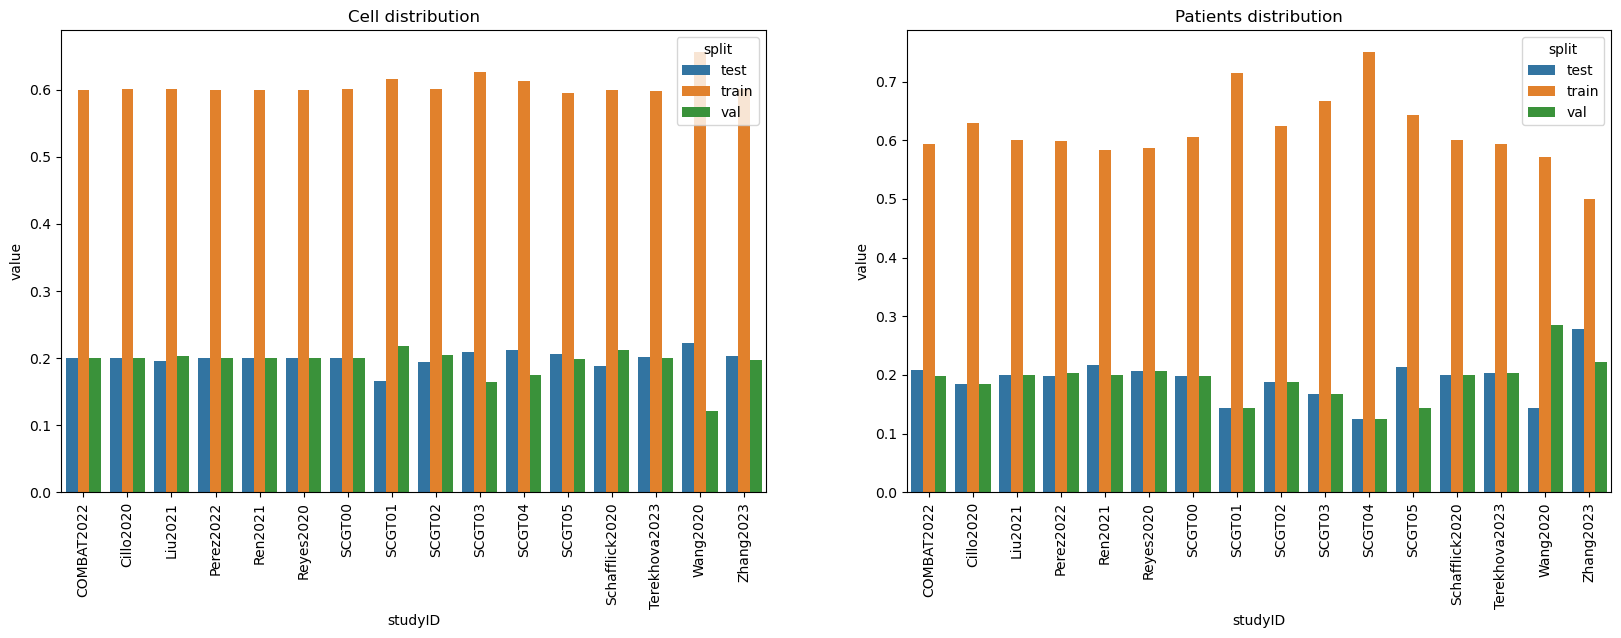

In [14]:
_, axs = plt.subplots(1, 2, figsize=(20, 6))
sns.barplot(x=target_y, y='value', hue='split', data=cell_plot_data, ax=axs[0])
axs[0].set_title('Cell distribution')
axs[0].tick_params(axis='x', labelrotation=90)
sns.barplot(x=target_y, y='value', hue='split', data=pat_plot_data, ax=axs[1])
axs[1].set_title('Patients distribution')
axs[1].tick_params(axis='x', labelrotation=90)

os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/01_split_plots/"), exist_ok=True)

plt.savefig(here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/01_split_plots/{RUN_NAME}{CELL_TYPE}_split_quality.pdf'), bbox_inches='tight', dpi=300)

In [15]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/02_preprocessing/"), exist_ok=True)

np.save(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/02_preprocessing/{RUN_NAME}{CELL_TYPE}_train_idxs.npy"), train_idxs)
np.save(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/02_preprocessing/{RUN_NAME}{CELL_TYPE}_val_idxs.npy"), val_idxs)
np.save(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/02_preprocessing/{RUN_NAME}{CELL_TYPE}_test_idxs.npy"), test_idxs)

### SUBSET DATASET INTO TRAIN/TEST/VAL SPLITS

In [16]:
X_train = adata.X[train_idxs]
X_test = adata.X[test_idxs]
X_val = adata.X[val_idxs]
X_train.shape, X_test.shape, X_val.shape

((427576, 935), (142811, 935), (141861, 935))

In [17]:
y_train = adata.obs.iloc[train_idxs][target_y].values.astype(str)
y_test = adata.obs.iloc[test_idxs][target_y].values.astype(str)
y_val = adata.obs.iloc[val_idxs][target_y].values.astype(str)
y_train.shape, y_test.shape, y_val.shape 

((427576,), (142811,), (141861,))

In [18]:
lenc = LabelEncoder()
y_train_enc = lenc.fit_transform(y_train)
y_val_enc = lenc.transform(y_val)
y_test_enc = lenc.transform(y_test)

### GENERATE F1 

In [19]:
def custom_f1_score(y_true, y_pred):
    return -f1_score(y_true, y_pred.argmax(1), average='weighted')

In [20]:
eval_metric=custom_f1_score
eval_metric_name='custom_f1_score'

def objective(trial):
    params = {
        'sampling_method': 'gradient_based',
        'n_estimators': 1500,
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 250),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.1, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 5e-1, log=True),
    }
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, f'validation_0-{eval_metric_name}')
    xgb = xgboost.XGBClassifier(
        device='gpu',
        eval_metric=eval_metric,
        early_stopping_rounds=20,
        callbacks=[pruning_callback],
        **params
    )
    xgb.fit(
        X_train, 
        y_train_enc, 
        verbose=0,
        eval_set=[(X_val, y_val_enc)],
    )
    trial.set_user_attr('best_iteration', xgb.best_iteration)

    return xgb.best_score

In [21]:
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)
wandb_kwargs = {"project": "xgboost", "name": f"{RUN_NAME}{CELL_TYPE}"}
wandbc = optuna.integration.WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs)
study.optimize(objective, n_trials=N_TRIALS, callbacks=[wandbc], gc_after_trial=True)

[I 2025-03-18 04:53:59,906] A new study created in memory with name: no-name-782c5f6b-f272-4d4e-914f-8cea279a626b


/tmp/ipykernel_1362290/350114600.py:4: ExperimentalWarning: WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.
  wandbc = optuna.integration.WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs)
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: dav1989 (inflammation) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Tracking run with wandb version 0.19.8


wandb: Run data is saved locally in /scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas/03_downstream_analysis/08_gene_importance/wandb/run-20250318_045404-i1da7mcc
wandb: Run `wandb offline` to turn off syncing.


wandb: Syncing run studyID_T_CD4_NonNaive


wandb: ⭐️ View project at https://wandb.ai/inflammation/xgboost


wandb: 🚀 View run at https://wandb.ai/inflammation/xgboost/runs/i1da7mcc


[I 2025-03-18 04:57:57,249] Trial 0 finished with value: -0.991057 and parameters: {'max_depth': 9, 'min_child_weight': 238, 'subsample': 0.7587945476302645, 'colsample_bynode': 0.6387926357773329, 'learning_rate': 0.0026368755339723046}. Best is trial 0 with value: -0.991057.


[I 2025-03-18 04:59:03,887] Trial 1 finished with value: -0.997325 and parameters: {'max_depth': 5, 'min_child_weight': 15, 'subsample': 0.8795585311974417, 'colsample_bynode': 0.6410035105688879, 'learning_rate': 0.08148293210105287}. Best is trial 1 with value: -0.997325.


[I 2025-03-18 05:03:12,258] Trial 2 finished with value: -0.991658 and parameters: {'max_depth': 3, 'min_child_weight': 243, 'subsample': 0.8491983767203796, 'colsample_bynode': 0.29110519961044856, 'learning_rate': 0.003095566460242371}. Best is trial 1 with value: -0.997325.


[I 2025-03-18 05:03:48,024] Trial 3 finished with value: -0.991141 and parameters: {'max_depth': 6, 'min_child_weight': 77, 'subsample': 0.5722807884690141, 'colsample_bynode': 0.48875051677790415, 'learning_rate': 0.006109683510122491}. Best is trial 1 with value: -0.997325.


[I 2025-03-18 05:06:05,372] Trial 4 finished with value: -0.995067 and parameters: {'max_depth': 14, 'min_child_weight': 35, 'subsample': 0.3629301836816964, 'colsample_bynode': 0.4297256589643226, 'learning_rate': 0.01701841881702917}. Best is trial 1 with value: -0.997325.


[I 2025-03-18 05:06:24,724] Trial 5 finished with value: -0.989693 and parameters: {'max_depth': 17, 'min_child_weight': 50, 'subsample': 0.5628109945722505, 'colsample_bynode': 0.6331731119758383, 'learning_rate': 0.0013346527038305934}. Best is trial 1 with value: -0.997325.


[I 2025-03-18 05:06:48,157] Trial 6 finished with value: -0.996907 and parameters: {'max_depth': 13, 'min_child_weight': 43, 'subsample': 0.1585464336867516, 'colsample_bynode': 0.9539969835279999, 'learning_rate': 0.4038423798071558}. Best is trial 1 with value: -0.997325.


[I 2025-03-18 05:06:55,192] Trial 7 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 05:07:02,726] Trial 8 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 05:07:13,229] Trial 9 pruned. Trial was pruned at iteration 4.


[I 2025-03-18 05:08:16,003] Trial 10 finished with value: -0.994899 and parameters: {'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.9725833997090791, 'colsample_bynode': 0.11616568805333755, 'learning_rate': 0.17780618353487967}. Best is trial 1 with value: -0.997325.


[I 2025-03-18 05:08:45,120] Trial 11 finished with value: -0.996663 and parameters: {'max_depth': 11, 'min_child_weight': 3, 'subsample': 0.35229864280210643, 'colsample_bynode': 0.9522656887511343, 'learning_rate': 0.4085535814821633}. Best is trial 1 with value: -0.997325.


[I 2025-03-18 05:08:53,959] Trial 12 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 05:09:02,581] Trial 13 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 05:09:11,392] Trial 14 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 05:09:21,003] Trial 15 pruned. Trial was pruned at iteration 1.


[I 2025-03-18 05:09:30,030] Trial 16 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 05:09:39,273] Trial 17 pruned. Trial was pruned at iteration 1.


[I 2025-03-18 05:09:47,842] Trial 18 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 05:09:56,823] Trial 19 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 05:10:26,234] Trial 20 finished with value: -0.997192 and parameters: {'max_depth': 20, 'min_child_weight': 19, 'subsample': 0.6483339605894612, 'colsample_bynode': 0.5117162566852926, 'learning_rate': 0.30169734010393523}. Best is trial 1 with value: -0.997325.


[I 2025-03-18 05:10:56,386] Trial 21 finished with value: -0.99696 and parameters: {'max_depth': 13, 'min_child_weight': 18, 'subsample': 0.6583033734853178, 'colsample_bynode': 0.5129739639406408, 'learning_rate': 0.3091260611497543}. Best is trial 1 with value: -0.997325.


[I 2025-03-18 05:11:31,475] Trial 22 finished with value: -0.99745 and parameters: {'max_depth': 20, 'min_child_weight': 14, 'subsample': 0.6581340170061017, 'colsample_bynode': 0.5071170970967006, 'learning_rate': 0.22750458457049225}. Best is trial 22 with value: -0.99745.


[I 2025-03-18 05:12:08,567] Trial 23 finished with value: -0.997104 and parameters: {'max_depth': 20, 'min_child_weight': 9, 'subsample': 0.8394472501839108, 'colsample_bynode': 0.4396097362124818, 'learning_rate': 0.09565119316681647}. Best is trial 22 with value: -0.99745.


[I 2025-03-18 05:12:17,446] Trial 24 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 05:12:25,996] Trial 25 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 05:12:35,356] Trial 26 pruned. Trial was pruned at iteration 1.


[I 2025-03-18 05:12:44,106] Trial 27 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 05:13:37,322] Trial 28 finished with value: -0.99806 and parameters: {'max_depth': 15, 'min_child_weight': 21, 'subsample': 0.7568099821915353, 'colsample_bynode': 0.6344449571551344, 'learning_rate': 0.11688838165310886}. Best is trial 28 with value: -0.99806.


[I 2025-03-18 05:13:45,831] Trial 29 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 05:13:55,010] Trial 30 pruned. Trial was pruned at iteration 1.


[I 2025-03-18 05:14:04,117] Trial 31 pruned. Trial was pruned at iteration 1.


[I 2025-03-18 05:14:13,097] Trial 32 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 05:14:33,031] Trial 33 pruned. Trial was pruned at iteration 25.


[I 2025-03-18 05:14:41,957] Trial 34 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 05:14:50,840] Trial 35 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 05:14:59,461] Trial 36 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 05:15:08,104] Trial 37 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 05:15:16,695] Trial 38 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 05:15:25,593] Trial 39 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 05:15:34,163] Trial 40 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 05:15:43,472] Trial 41 pruned. Trial was pruned at iteration 2.


[I 2025-03-18 05:15:53,991] Trial 42 pruned. Trial was pruned at iteration 5.


[I 2025-03-18 05:16:02,975] Trial 43 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 05:16:38,159] Trial 44 finished with value: -0.997249 and parameters: {'max_depth': 18, 'min_child_weight': 1, 'subsample': 0.9391918977127081, 'colsample_bynode': 0.5962191274134194, 'learning_rate': 0.17646113726309132}. Best is trial 28 with value: -0.99806.


[I 2025-03-18 05:16:51,288] Trial 45 pruned. Trial was pruned at iteration 9.


[I 2025-03-18 05:16:59,774] Trial 46 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 05:17:08,408] Trial 47 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 05:17:40,527] Trial 48 finished with value: -0.998254 and parameters: {'max_depth': 14, 'min_child_weight': 38, 'subsample': 0.5704269720802206, 'colsample_bynode': 0.5931030179720626, 'learning_rate': 0.2472093300852475}. Best is trial 48 with value: -0.998254.


[I 2025-03-18 05:17:49,188] Trial 49 pruned. Trial was pruned at iteration 0.


In [22]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/study/"), exist_ok=True)

joblib.dump(study, here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/study/{RUN_NAME}{CELL_TYPE}_xgboost.pkl'))

['/scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas/03_downstream_analysis/08_gene_importance/results/targetY_studyID/03_xgboost/study/studyID_T_CD4_NonNaive_xgboost.pkl']

In [23]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/parallel_coordinate/"), exist_ok=True)

fig = optuna.visualization.plot_parallel_coordinate(study)
fig.write_image(here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/parallel_coordinate/{RUN_NAME}{CELL_TYPE}_pcoord.pdf'))

In [24]:
n_estimators = int(study.best_trial.user_attrs['best_iteration']*1.2)
xgb = xgboost.XGBClassifier(
        device='gpu',
        eval_metric=eval_metric,
        n_estimators=n_estimators,
        **study.best_trial.params
    )
xgb.fit(
    ssp.vstack((X_train, X_val)), 
    np.concatenate((y_train_enc, y_val_enc)), 
    eval_set=[(X_test, y_test_enc)],
    verbose=1,
)

[0]	validation_0-mlogloss:1.13642	validation_0-custom_f1_score:-0.96569


[1]	validation_0-mlogloss:0.84766	validation_0-custom_f1_score:-0.96964


[2]	validation_0-mlogloss:0.65759	validation_0-custom_f1_score:-0.96939


[3]	validation_0-mlogloss:0.51792	validation_0-custom_f1_score:-0.97251


[4]	validation_0-mlogloss:0.41378	validation_0-custom_f1_score:-0.97293


[5]	validation_0-mlogloss:0.33636	validation_0-custom_f1_score:-0.97260


[6]	validation_0-mlogloss:0.27643	validation_0-custom_f1_score:-0.97265


[7]	validation_0-mlogloss:0.22939	validation_0-custom_f1_score:-0.97314


[8]	validation_0-mlogloss:0.19280	validation_0-custom_f1_score:-0.97349


[9]	validation_0-mlogloss:0.16401	validation_0-custom_f1_score:-0.97353


[10]	validation_0-mlogloss:0.14176	validation_0-custom_f1_score:-0.97373


[11]	validation_0-mlogloss:0.12360	validation_0-custom_f1_score:-0.97412


[12]	validation_0-mlogloss:0.10920	validation_0-custom_f1_score:-0.97409


[13]	validation_0-mlogloss:0.09783	validation_0-custom_f1_score:-0.97428


[14]	validation_0-mlogloss:0.09003	validation_0-custom_f1_score:-0.97407


[15]	validation_0-mlogloss:0.08283	validation_0-custom_f1_score:-0.97414


[16]	validation_0-mlogloss:0.07767	validation_0-custom_f1_score:-0.97416


[17]	validation_0-mlogloss:0.07341	validation_0-custom_f1_score:-0.97433


[18]	validation_0-mlogloss:0.07024	validation_0-custom_f1_score:-0.97431


[19]	validation_0-mlogloss:0.06748	validation_0-custom_f1_score:-0.97448


[20]	validation_0-mlogloss:0.06471	validation_0-custom_f1_score:-0.97505


[21]	validation_0-mlogloss:0.06280	validation_0-custom_f1_score:-0.97516


[22]	validation_0-mlogloss:0.06095	validation_0-custom_f1_score:-0.97547


[23]	validation_0-mlogloss:0.06006	validation_0-custom_f1_score:-0.97552


[24]	validation_0-mlogloss:0.05900	validation_0-custom_f1_score:-0.97555


[25]	validation_0-mlogloss:0.05783	validation_0-custom_f1_score:-0.97581


[26]	validation_0-mlogloss:0.05712	validation_0-custom_f1_score:-0.97576


[27]	validation_0-mlogloss:0.05625	validation_0-custom_f1_score:-0.97601


[28]	validation_0-mlogloss:0.05594	validation_0-custom_f1_score:-0.97626


[29]	validation_0-mlogloss:0.05592	validation_0-custom_f1_score:-0.97637


[30]	validation_0-mlogloss:0.05625	validation_0-custom_f1_score:-0.97656


[31]	validation_0-mlogloss:0.05558	validation_0-custom_f1_score:-0.97693


[32]	validation_0-mlogloss:0.05629	validation_0-custom_f1_score:-0.97674


[33]	validation_0-mlogloss:0.05594	validation_0-custom_f1_score:-0.97684


[34]	validation_0-mlogloss:0.05639	validation_0-custom_f1_score:-0.97662


[35]	validation_0-mlogloss:0.05670	validation_0-custom_f1_score:-0.97644


[36]	validation_0-mlogloss:0.05598	validation_0-custom_f1_score:-0.97668


[37]	validation_0-mlogloss:0.05540	validation_0-custom_f1_score:-0.97698


[38]	validation_0-mlogloss:0.05584	validation_0-custom_f1_score:-0.97693


[39]	validation_0-mlogloss:0.05577	validation_0-custom_f1_score:-0.97693


[40]	validation_0-mlogloss:0.05595	validation_0-custom_f1_score:-0.97681


[41]	validation_0-mlogloss:0.05585	validation_0-custom_f1_score:-0.97686


[42]	validation_0-mlogloss:0.05579	validation_0-custom_f1_score:-0.97682


[43]	validation_0-mlogloss:0.05608	validation_0-custom_f1_score:-0.97662


[44]	validation_0-mlogloss:0.05611	validation_0-custom_f1_score:-0.97659


[45]	validation_0-mlogloss:0.05603	validation_0-custom_f1_score:-0.97665


[46]	validation_0-mlogloss:0.05585	validation_0-custom_f1_score:-0.97678


[47]	validation_0-mlogloss:0.05591	validation_0-custom_f1_score:-0.97671


[48]	validation_0-mlogloss:0.05596	validation_0-custom_f1_score:-0.97670


[49]	validation_0-mlogloss:0.05591	validation_0-custom_f1_score:-0.97674


[50]	validation_0-mlogloss:0.05601	validation_0-custom_f1_score:-0.97673


[51]	validation_0-mlogloss:0.05617	validation_0-custom_f1_score:-0.97664


[52]	validation_0-mlogloss:0.05623	validation_0-custom_f1_score:-0.97663


[53]	validation_0-mlogloss:0.05591	validation_0-custom_f1_score:-0.97677


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=0.5931030179720626,
              colsample_bytree=None, device='gpu', early_stopping_rounds=None,
              enable_categorical=False,
              eval_metric=<function custom_f1_score at 0x76a5be44d9e0>,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2472093300852475, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=14, max_leaves=None,
              min_child_weight=38, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=54, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [25]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/best_model/"), exist_ok=True)

joblib.dump(xgb, (here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/best_model/{RUN_NAME}{CELL_TYPE}_xgb.json')))

['/scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas/03_downstream_analysis/08_gene_importance/results/targetY_studyID/03_xgboost/best_model/studyID_T_CD4_NonNaive_xgb.json']

In [26]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/predictions/"), exist_ok=True)

(pd.DataFrame(np.array((y_test, y_test_enc, xgb.predict(X_test))).T, columns=['y_true', 'y_true_code', 'y_pred'])
 .to_csv(here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/predictions/{RUN_NAME}{CELL_TYPE}_pred_test.zip')))
(pd.DataFrame(np.array((y_train, y_train_enc, xgb.predict(X_train))).T, columns=['y_true', 'y_true_code', 'y_pred'])
 .to_csv(here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/predictions/{RUN_NAME}{CELL_TYPE}_pred_train.zip')))

/scratch_isilon/groups/singlecell/shared/conda_env/xgboostGPU/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning:

[05:18:31] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076482591/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.


